# Homework 8
## Question 12: Schrödinger Equation momentum 
Obtain an expression analytically for the expectation value of the momentum of a quantum particle, $\left\langle p \right\rangle$ (recall that $\hat{p}$ = $−i\hbar \frac{ \partial}{\partial x}$ ).
Modify the schro.py program to compute $\left\langle p \right\rangle$. Plot $\left\langle p \right\rangle$ versus time for various values
of $N$ (the number of grid points). Is momentum conserved? Repeat this exercise using
the Dirichlet boundary conditions, $\psi(x = ±L/2)$ = 0.

### Implementation:
<!-- After simplifying $\left\langle p \right\rangle$ = $\int^\infty_{-\infty} \psi^* \hat{p} \psi$
 -->
For a Gaussian wave packet:

$$ \psi = Ne^{i k_0 x} e^-\frac{(x-x_0)^2}{(2\sigma)^2}$$

Acting the momentum operator $\hat{p}$ on $\psi$ yields:

$$ \hat{p}\psi = -i \hbar N e^{i k_0 x} e^\frac{-(x - x0)^2}{2\sigma_0^2} (i k_0 - \frac{x - x_0}{\sigma_0^2}) $$,

Since the expectation value of momentum is given by
$$\left\langle p \right\rangle = \int^\infty_{-\infty} \psi^* \hat{p} \psi$$

we discretize our wave functions as such:
$$\left\langle p \right\rangle = \int^\infty_{-\infty} \psi_{n+1}^* \hat{p} \psi_{n+1}$$

which will be advanced with the Crank-Nicolson method
$$\psi^{n+1} = (1 + i\frac{\Delta t}{ 2\hbar} \hat{H})^{-1} (1 - i\frac{\Delta t}{ 2\hbar} \hat{H})^{-1} \psi^n $$



Below is a user defined function that will allow us to see the expectation value for momentum at various values of N.
A flag is included to investigate with/out Dirichlet boundary conditions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def hw8(N, flag):
    '''
    N : Number of gridpoints
    flag : If greater than 0, enforce dirichlet boundary conditions, else, don't
    '''
    # Initialize parameters (grid spacing, time step, etc.)
    i_imag = 1j  # imaginary i in Python

    # N = eval(input('enter number of grid points: '))
#     N = 100

    L = 100.0  # System extends from -L/2 to L/2
    dx = L / (N - 1)  # Grid size
    x = np.arange(N) * dx - L / 2.0  # Coordinates of grid points.
    hbar = 1.0  # Natural units
    mass = 1.0  # Natural units
    # dt = eval(input('Enter time step: '))
    dt = .01

    # Set up the Hamiltonian operator matrix
    ham = np.zeros((N, N))  # Set all elements to zero.
    coeff = -hbar**2 / (2 * mass * dx**2)

    for i in range(1, N - 1):
        ham[i, i - 1] = coeff
        ham[i, i] = -2 * coeff  # Set interior rows
        ham[i, i + 1] = coeff

    # First and last rows for periodic boundary conditions
#     ham[0, -1] = coeff
#     ham[0, 0] = -2 * coeff
#     ham[0, 1] = coeff

#     ham[-1, -2] = coeff
#     ham[-1, -1] = -2 * coeff
#     ham[-1, 0] = coeff

    # Compute the Crank-Nicolson Matrix
    dCN = np.dot(
        np.linalg.inv(np.identity(N) + 0.5 * i_imag * dt / hbar * ham),
        (np.identity(N) - 0.5 * i_imag * dt / hbar * ham))

    # Initialize the wavefunction
    x0 = 0.0  # Location of the center of the wavepacket
#     velocity = 0.5  # Average velocity of the packet
    velocity = 1  # Average velocity of the packet
    k0 = mass * velocity / hbar  # Average wavenumber
    sigma0 = L / 10.0  # Standard deviation of the wavefunction
    Norm_psi = 1.0 / np.sqrt(sigma0 * np.sqrt(np.pi))
    
    psi = np.empty(N, dtype=complex)  # Initialize wavefunction as an array
    psiMom = np.empty(N, dtype=complex)
    
    for q in range(N):

        psi[q] = Norm_psi * np.exp(i_imag * k0 * x[q]) * np.exp(
            -(x[q] - x0)**2 / (2 * sigma0**2))


        psiMom[q] = -i_imag * hbar * N * np.exp(
            i_imag * k0 * x[q]) * np.exp(
            -(x[q] - x0)**2 / (2*sigma0**2)) * (i_imag * k0 - (x[q] - x0) / sigma0**2)

#     # Plot the initial wavefunction
#     fig, ax = plt.subplots()
#     ax.plot(x, np.real(psi), ls='-', label='Real')
#     ax.plot(x, np.imag(psi), ls='--', label='Imag')
#     ax.set_xlabel('x')
#     ax.set_ylabel(r'$\psi(x)$')
#     ax.set_title(
#         r'Initial Wavefunction, N = {0:d}, $\Delta t = ${1:.2f}'.format(N, dt))
#     ax.legend()

#     plt.show()

    # Initialize loop and plotting variables
    max_iter = int(
        L / (velocity * dt) + 0.5
    )  # Max iterations such that the particle circles the system at least once
    plot_iter = max_iter / 8
    p_plot = np.zeros(
        (N, max_iter + 1))  # Note probability density P(x,t) is real
    mom_plot = np.zeros(max_iter + 1)
    p_plot[:, 0] = np.abs(psi)**2  # Record initial probability density
    iplot = 0

    # Loop over desired number of steps (wave circles the system once)
    for iter in range(max_iter):
        if flag > 0:
            psi[0] = 0
            psi[-1] = 0
            
        # Compute new wavefunction using the Crank-Nicoloson method
        psi = np.dot(dCN, psi)
        
        psiMom = np.dot(dCN, psiMom)
        
        # Normalize after every time step to help with truncation errors.
        norm = dx * np.sum(np.abs(psi)**2)
        psi = psi / np.sqrt(norm)

        normMom = dx * np.sum(np.abs(psiMom)**2)
        psiMom = psiMom / np.sqrt(norm)
        
        expecP = np.dot(np.conj(psi), psiMom).sum()
        mom_plot[iter] = expecP.real

        # Periodically record values for plotting
        if (iter + 1) % plot_iter < 1:
            iplot += 1
            p_plot[:, iplot] = np.abs(psi)**2
#             mom_plot[iplot] = expecP.real
            
            norm_check = dx * np.sum(np.abs(psi)**2)  # This should always be one. If it's not, you have a bug.
#             print(
#                 ('Finished {0:d} of {1:d} iterations.'.format(iter, max_iter)))
#             print('WF Norm: {0:.2f}'.format(norm_check))

    # Plot probability vs. position at various times.
    pFinal = np.abs(psi)**2

#     fig2, ax2 = plt.subplots()
#     ax2.plot(x,
#              p_plot[:, 0],
#              ls=':',
#              color='black',
#              linewidth=1.75,
#              label='Initial')
#     for m in range(1, iplot + 1):
#         ax2.plot(x, p_plot[:, m], label='_nolegend_'
#                  )  # No legend labels for all the intermediate time plots
#     ax2.plot(x, pFinal, ls='--', color='k', linewidth=1.75, label='Final')
#     ax2.set_xlabel('x')
#     ax2.set_ylabel('P(x,t)')
# #     ax2.set_xlim(-L / 2.0, L / 2.0)
# #     ax2.set_ylim(0.0, 1.1 * max(p_plot[:, 0]))
#     ax2.set_title(
#         'Probability density at various times. N = {0:d}, $\Delta t = ${1:.3f}'
#         .format(N, dt))
#     ax2.legend()

    plt.figure()
    
    plt.plot(dt*np.arange(0, max_iter), mom_plot[:-1], 'k.')
    plt.ylim(0, 2*np.max(mom_plot) )
    plt.title(f'<p> vs time , N = {N}')
    if flag > 0:
        plt.title(f'<p> vs time with Dirichlet BCs, N = {N}')
    plt.xlabel('time')
    plt.ylabel('<p>')
    return(np.mean(mom_plot))


###

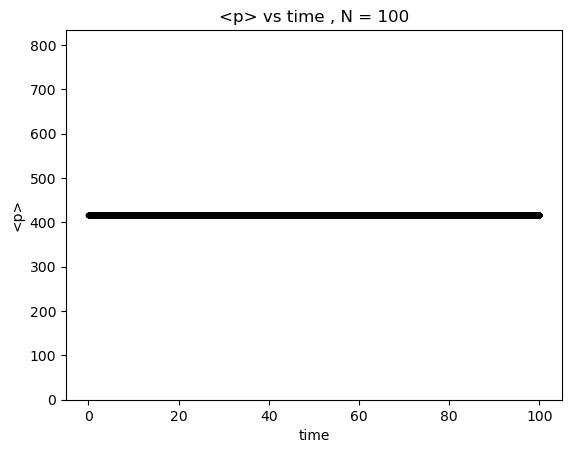

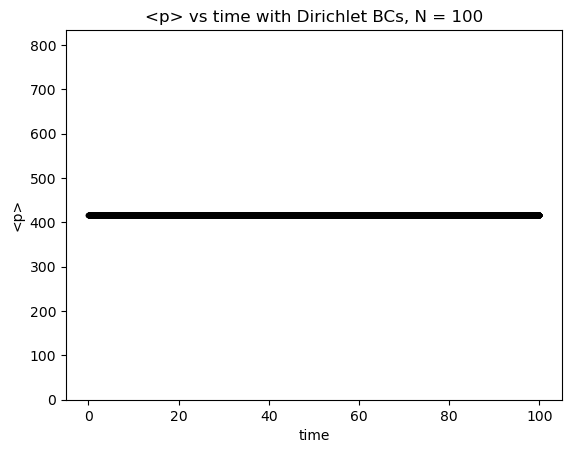

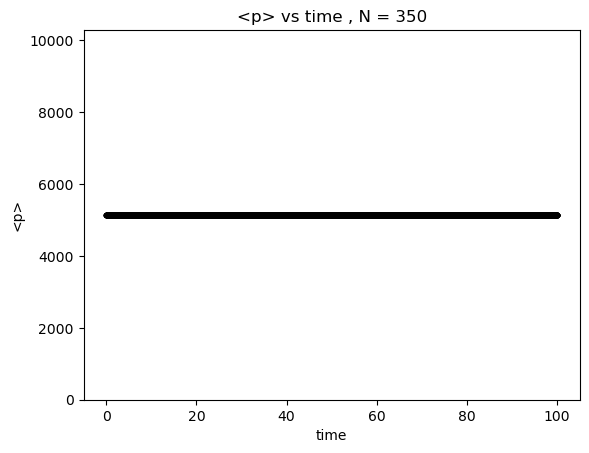

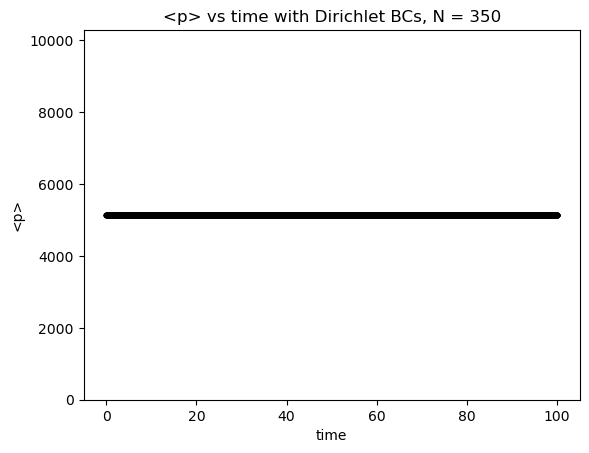

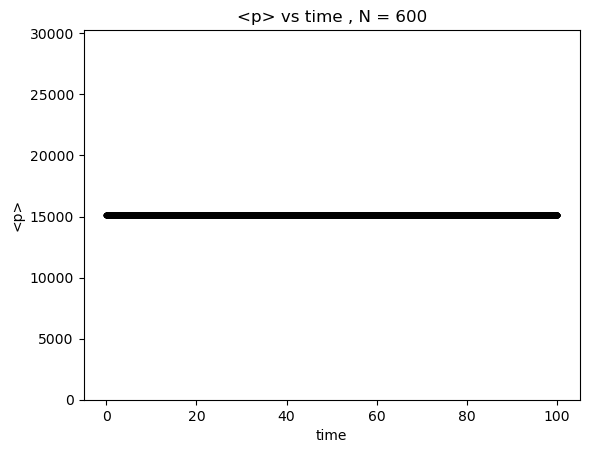

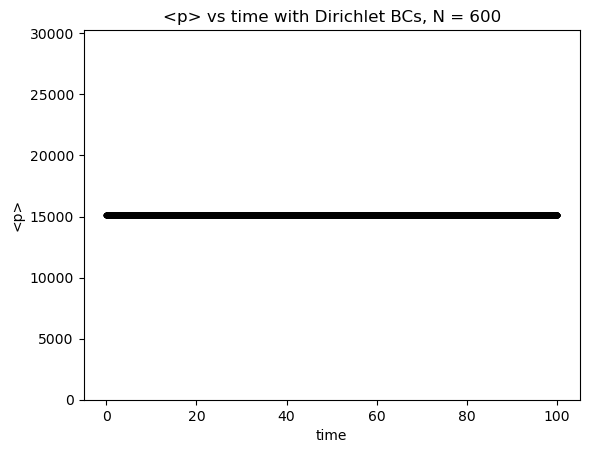

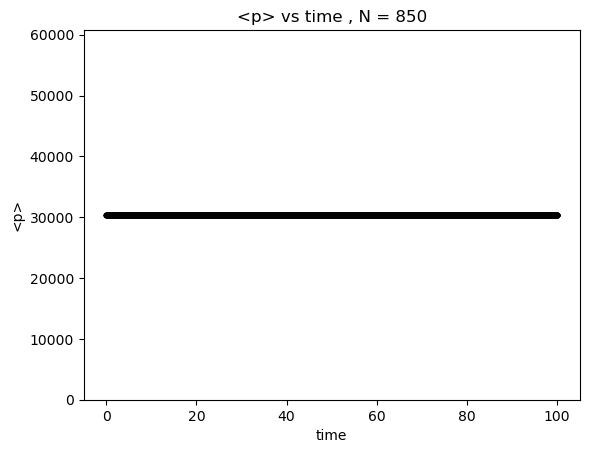

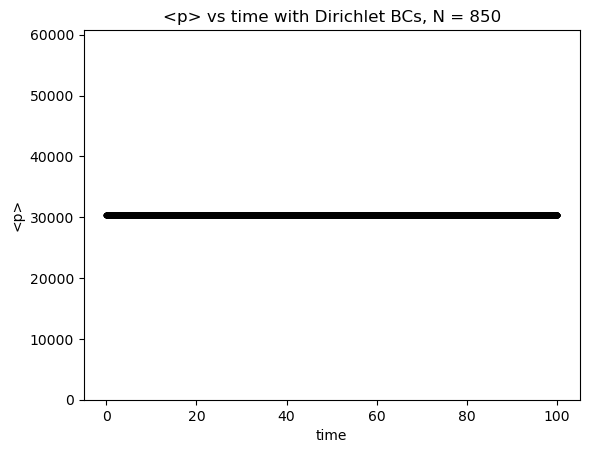

In [3]:
#n_vals = np.arange(40, 100, 20)
n_vals = np.arange(100, 1000, 250)

mom_vals = np.zeros(len(n_vals))
mom_valsBC = np.zeros(len(n_vals))
for i, n in enumerate(n_vals):
    mom_vals[i] = hw8(n, 0) # 0 for no BCs
    mom_valsBC[i] = hw8(n, 1) # 1 for Dirichlet BCs


# Conclusion
Above are the plots that detail the behavior of momentum's expectation value over time as the number of grid points $N$ increases. We notice that the value increases as N increases, which suggests that momentum is not conserved, suggesting either something incorrect about the implementation or a failure of the method. Something we also notice is the stability of the method's solution for the expectation value, which must be related to how the Crank-Nicolson method is unconditionally stable. 
